# Fruit recognition

In [2]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pathlib

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Flatten, SeparableConv2D, Conv2D ,BatchNormalization, Activation
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
#transfer learning models 
from tensorflow.keras.applications import EfficientNetV2S, Xception, MobileNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


We will be using a simulare method to identify fruit live.
Providing a dataset with fruits and we will instead use transferlearning as the images are now in rgb
making it possible to use the trained 3 channel weights from imagenet.
Another script will be provided so that we can use our camera and identify fruits live

# Dataset
First source was changed as it performed bad

In [4]:
#source: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition/data
folder_path = "new_images/"

#old source: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition/data
"""labels = ['banana','beetroot','corn','orange','kiwi','ginger','mango','jalepeno'
,'turnip','cabbage','raddish','carrot','bell pepper','lettuce','spinach'
,'chilli pepper','pear','apple','peas','pineapple','eggplant','grapes'
,'tomato','cucumber','paprika','capsicum','sweetcorn','watermelon'
,'pomegranate','lemon','soy beans','sweetpotato','onion','cauliflower'
,'garlic','potato']
label = labels[3]
print(label)"""

"labels = ['banana','beetroot','corn','orange','kiwi','ginger','mango','jalepeno'\n,'turnip','cabbage','raddish','carrot','bell pepper','lettuce','spinach'\n,'chilli pepper','pear','apple','peas','pineapple','eggplant','grapes'\n,'tomato','cucumber','paprika','capsicum','sweetcorn','watermelon'\n,'pomegranate','lemon','soy beans','sweetpotato','onion','cauliflower'\n,'garlic','potato']\nlabel = labels[3]\nprint(label)"

In [173]:
data_dir = pathlib.Path(folder_path+"train/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)
label = class_names[4]
classes = len(class_names)
print(classes)

['Apple Braeburn' 'Apple Granny Smith' 'Apricot' 'Avocado' 'Banana'
 'Blueberry' 'Cactus fruit' 'Cantaloupe' 'Cherry' 'Clementine' 'Corn'
 'Cucumber Ripe' 'Grape Blue' 'Kiwi' 'Lemon' 'Limes' 'Mango' 'Onion White'
 'Orange' 'Papaya' 'Passion Fruit' 'Peach' 'Pear' 'Pepper Green'
 'Pepper Red' 'Pineapple' 'Plum' 'Pomegranate' 'Potato Red' 'Raspberry'
 'Strawberry' 'Tomato' 'Watermelon']
33


Checking images

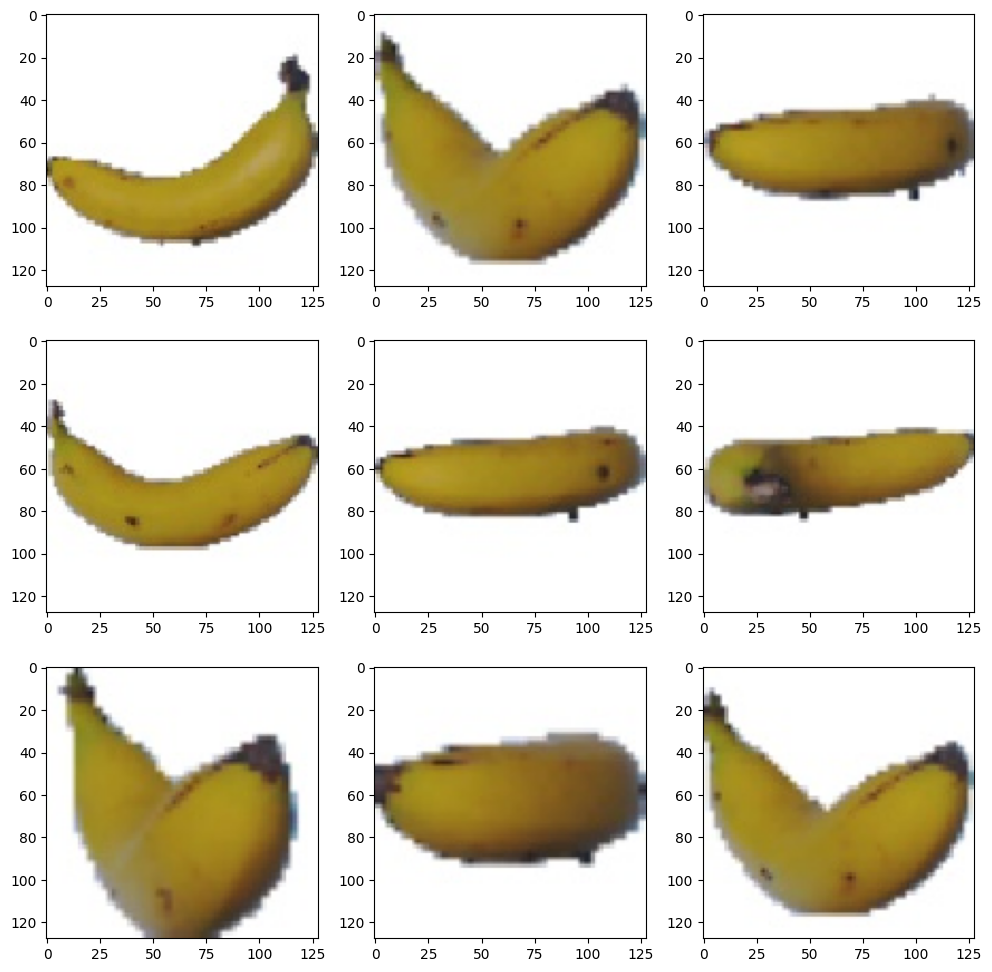

In [163]:
image_size = 128

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+label+"/"+
                  os.listdir(folder_path + "train/" + label)[i], target_size=(image_size, image_size))
    plt.imshow(img)   
plt.show()

In [172]:
batch_size  = 32

#modifying images with imagedatagenerator
#so that the images will be slightly different from the validation set
#thus making the model not overfit
#all images should be normaliside to 0-1 thus we rescale by 255 per pixel
datagen_train  = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    zoom_range=0.1,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.2 #by using split and subsets we can split the data like train test split
                                    )

testgen_val = ImageDataGenerator(rescale=1./255)

train_set_new = datagen_train.flow_from_directory(folder_path+"train",
                                                  target_size = (image_size,image_size),
                                                  color_mode = "rgb",
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='training',
                                                  shuffle=True,)


val_set_new = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (image_size,image_size),
                                              color_mode = "rgb",
                                              batch_size=16,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False)

Found 13493 images belonging to 33 classes.
Found 3361 images belonging to 33 classes.


# Build model, using Transfer-learning

In [174]:
MobileNetV2_model = MobileNetV2(input_shape=(image_size, image_size, 3),            
                                include_top=False,                   
                                weights='imagenet',                  
                                pooling='avg'                        
                                )
MobileNetV2_model.trainable = False
MobileNetV2_model.summary()
print(MobileNetV2_model.trainable)

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

other models have been tested but mobilenet seems to work good enough and does not take as much storage space.
Refer to :https://keras.io/api/applications/ to see model sizes

In [175]:
#note that the transformed model is frozen and we are adding layers that we may train weights on.
#providing more layers might improve but it might also just cause dead neurones
model = Sequential()

model.add(MobileNetV2_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(classes, activation='softmax'))

opt = Adam(learning_rate = 0.0001, decay=1e-5)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_9 (Flatten)         (None, 1280)              0         
                                                                 
 dense_27 (Dense)            (None, 256)               327936    
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dense_29 (Dense)            (None, 33)                4257      
                                                                 
Total params: 2,623,073
Trainable params: 365,089
Non-trainable params: 2,257,984
_____________________________________

In [176]:
#callbacks
checkpoint_cb = ModelCheckpoint('MyModel.h5', save_best_only=True, verbose = 1) 

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True, verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

callbacks_list = [earlystop_cb,checkpoint_cb,reduce_lr]

epochs = 48

In [177]:
history = model.fit(x=train_set_new,
                            steps_per_epoch=len(train_set_new),
                            epochs=epochs,
                            validation_data=val_set_new,
                            validation_steps=len(val_set_new),
                            callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/48
422/422 [==============================] - 59s 134ms/step - loss: 1.0496 - accuracy: 0.7840 - val_loss: 0.1863 - val_accuracy: 0.9747 - lr: 1.0000e-04
Epoch 2/48
422/422 [==============================] - 50s 118ms/step - loss: 0.1148 - accuracy: 0.9843 - val_loss: 0.0678 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 3/48
422/422 [==============================] - 50s 118ms/step - loss: 0.0522 - accuracy: 0.9927 - val_loss: 0.0426 - val_accuracy: 0.9946 - lr: 1.0000e-04
Epoch 4/48
422/422 [==============================] - 51s 120ms/step - loss: 0.0312 - accuracy: 0.9956 - val_loss: 0.0254 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 5/48
422/422 [==============================] - 53s 126ms/step - loss: 0.0234 - accuracy: 0.9961 - val_loss: 0.0177 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 6/48
422/422 [==============================] - 51s 122ms/step - loss: 0.0190 - accuracy: 0.9963 - val_loss: 0.0157 - val_accuracy: 0.9967 - lr: 1.0000e-04
Epoch 7/48
422/422 [========

In [178]:
model.save("mobilenet_model_newdata.h5")

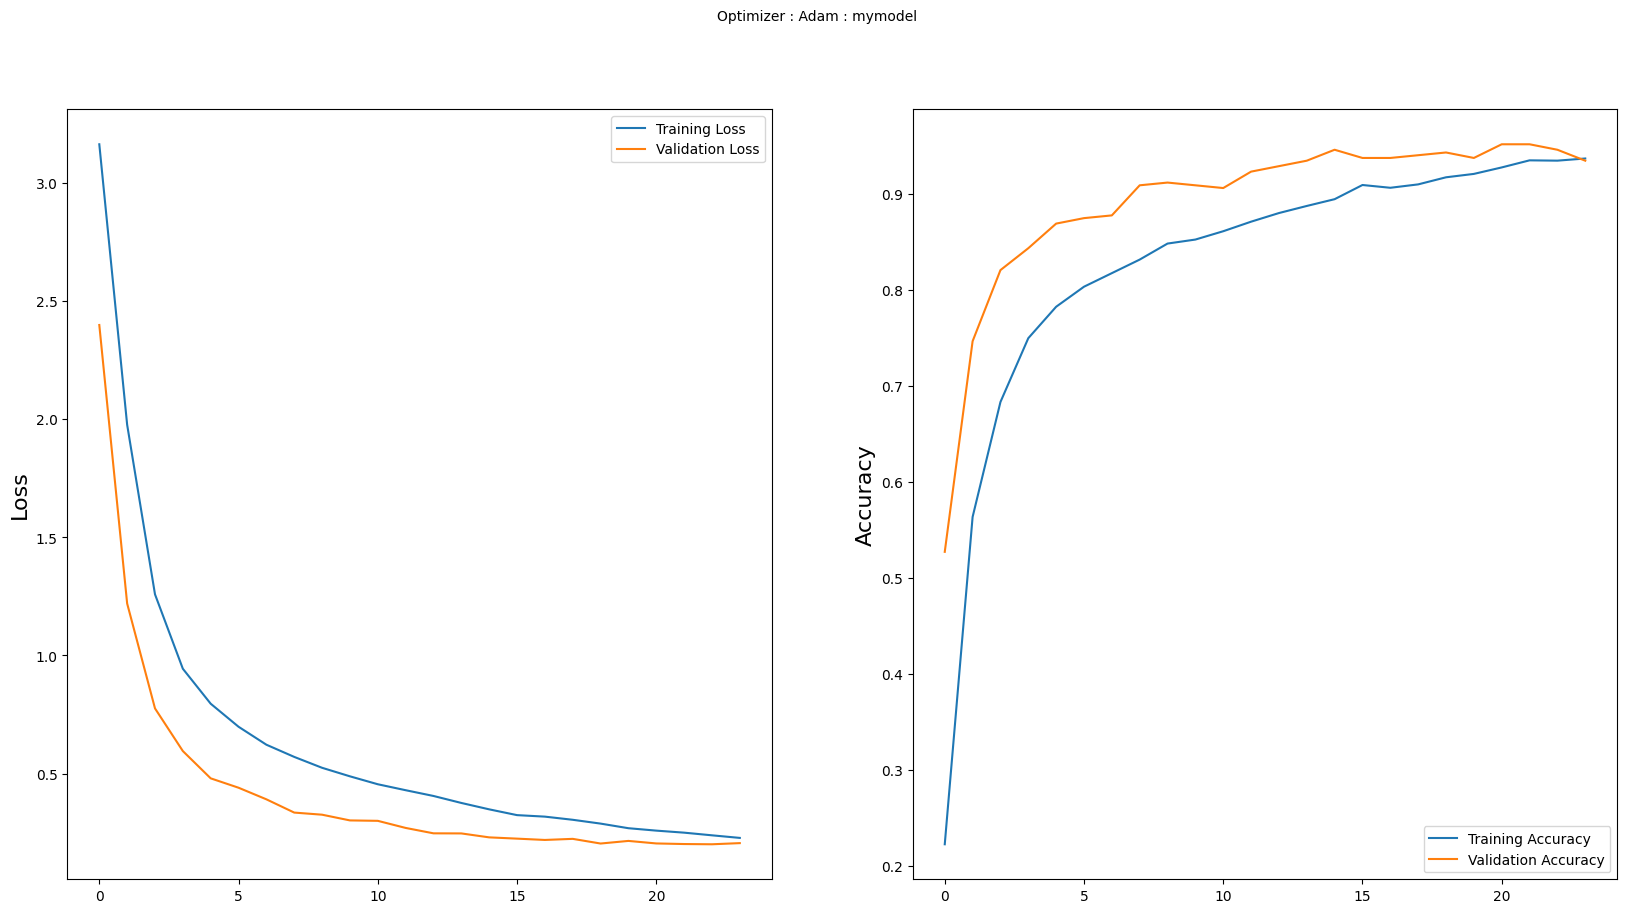

In [32]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam : mymodel', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

It is difficult to say what to do with the model as accuracy and val accuracy are very high.

just because the val accuracy is high it does not mean that the product will provide good results
thus only live testing will provide somewhat of efficient information.

increasing layers might not be ideal with the current information we have nor will changing the chosen transfer model

testing and evaluating model

In [91]:
model_pred = model.predict(test_set)

12/12 [==============================] - 9s 753ms/step


In [94]:
len(test_set.labels)

359

In [100]:
x, y =test_set.next()
x[0].shape
testx = x[0].reshape(1, 224, 224, 3)
testx.shape

(1, 224, 224, 3)

In [101]:
test_pred = model.predict(testx)

1/1 [==============================] - 0s 95ms/step


In [111]:
np.argmax(test_pred[0])

19

In [44]:
test_set.labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22,
       22, 22, 22, 22, 22

In [51]:
k = np.zeros(classes, dtype=int)
for i in range(len(test_set.labels)):
    k[test_set.labels[i]] = k[test_set.labels[i]]+1
print(k)

[10  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10]


In [53]:
j = np.zeros(classes, dtype=int)
for i in range(len(model_pred)):
    j[np.argmax(model_pred[i])] = j[np.argmax(model_pred[i])]+1
print(j)
print(j/k)
print(sum(j/k)/36)

[11  7 10 18 10  3 10 10 13  6 10 10 10 10 10 10 10 12 10 11 10  9  9 10
 10 10 10  7 10  9 10 14 10 10 10 10]
[1.1        0.77777778 1.         1.8        1.         0.3
 1.         1.         1.3        0.6        1.         1.
 1.         1.         1.         1.         1.         1.2
 1.         1.1        1.         0.9        0.9        1.
 1.         1.         1.         0.7        1.         0.9
 1.         1.4        1.         1.         1.         1.        ]
0.9993827160493827


In [61]:
print((j/k)[5])
print(labels[5])

0.3
ginger


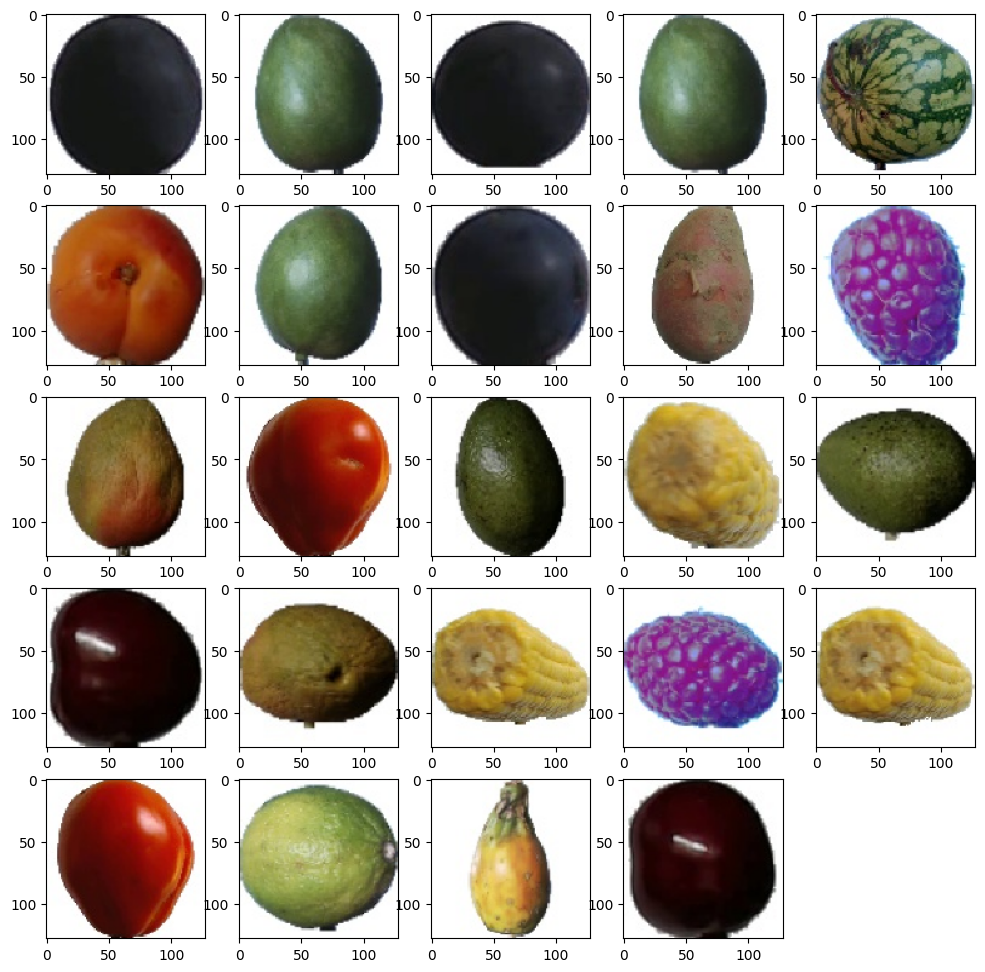

In [199]:
plt.figure(figsize= (12,12))
for i in range(1, 25, 1):
    plt.subplot(5,5,i)
    img = load_img(folder_path+"test/"+
                  os.listdir(folder_path + "test/")[i], target_size=(image_size, image_size))
    plt.imshow(img)   
plt.show()

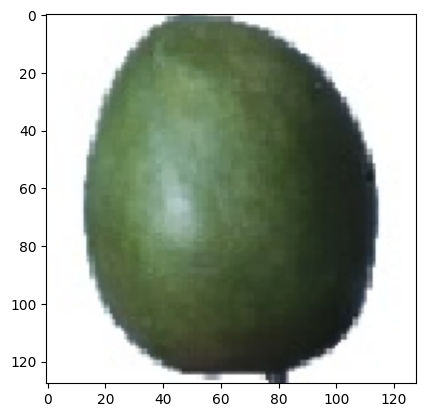

In [207]:
img = load_img(folder_path+"test/"+os.listdir(folder_path + "test/")[4], target_size=(image_size, image_size))
plt.imshow(img)   
imgarray = img_to_array(img)/255
reshaped = imgarray.reshape(1, 128, 128, 3)

In [208]:
model_pred = model.predict(reshaped)

1/1 [==============================] - 0s 27ms/step


In [209]:
print(np.argmax(model_pred[0]))
print(class_names[np.argmax(model_pred[0])])

16
Mango


Insight will be provided in the Main.py file please read notes over there.